In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from skorch import NeuralNetClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix
    , accuracy_score, ConfusionMatrixDisplay
    )
from torchmetrics import Accuracy, ConfusionMatrix
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from timeit import default_timer as timer
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [2]:
# MacoOS device agnostic code:

if torch.cuda.is_available():
    device = "cuda" # Use NVIDIA GPU (if available)
elif torch.backends.mps.is_available():
    device = "mps" # Use Apple Silicon GPU (if available)
else:
    device = "cpu" # Default to CPU if no GPU is available

device

'mps'

In [3]:
# ---------------------------------------------------------
# Dataset Preparation
# ---------------------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor()
    , transforms.Normalize((0.5,), (0.5,))
])

# Load datasets (train/test split handled by FashionMNIST)
train_dataset = datasets.FashionMNIST(
    './data', train=True
    , download=True, transform=transform)

test_dataset = datasets.FashionMNIST(
    './data', train=False
    , download=True, transform=transform)

# Use DataLoaders directly, avoiding manual tensor creation
train_loader = DataLoader(
    train_dataset
    , batch_size=256
    , shuffle=True)

test_loader = DataLoader(
    test_dataset
    , batch_size=256
    , shuffle=False)

In [3]:
# # Skorch can handle PyTorch Datasets directly
# X_train, y_train = train_dataset.data.float().unsqueeze(1), train_dataset.targets
# X_test, y_test = test_dataset.data.float().unsqueeze(1), test_dataset.targets

In [4]:
# X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [4]:
# Define the CNN Module

class SimpleCNN(nn.Module):
    def __init__(self, channels=32, dropout=0.0):
        super().__init__()
        self.conv1 = nn.Conv2d(1, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear((channels * 2) * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(self.dropout(x)))
        return self.fc2(x)

In [5]:
# Wrap with Skorch NeuralNetClassifier
net = NeuralNetClassifier(
    module=SimpleCNN
    , criterion=nn.CrossEntropyLoss
    , max_epochs=3
    , lr=0.001
    , optimizer=torch.optim.Adam
    , batch_size=256
    , iterator_train__shuffle=True
    , device=device
)

# Fit the model
net.fit(train_dataset.data.float().unsqueeze(1), train_dataset.targets)

print("Train accuracy:", net.score(
    train_dataset.data.float().unsqueeze(1)
    , train_dataset.targets))

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.1194       0.8795        0.3395  14.3271
      2        0.3143       0.8852        0.3157  12.5209
      3        0.2704       0.8962        0.2885  12.4446
Train accuracy: 0.9068166666666667


In [7]:
%%time

# RandomizedSearchCV for Hyperparameter Tuning

param_dist = {
    "module__channels": [32, 64]
    , "module__dropout": [0.0, 0.25, 0.5]
    , "lr": [1e-4, 3e-4, 1e-3]
    , "optimizer": [torch.optim.Adam]
    , "batch_size": [256]
}

rs = RandomizedSearchCV(
    estimator=net
    , param_distributions=param_dist
    , n_iter=10
    , cv=2
    , scoring="accuracy"
    , verbose=1
    , random_state=27
    , n_jobs=-1
)

rs.fit(train_dataset.data.float().unsqueeze(1), train_dataset.targets)

print("Best CV accuracy:", rs.best_score_)
print("Best params:", rs.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2033       0.8555        0.4161  8.5565
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.6643       0.8492        0.4259  8.6235
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3041       0.8422        0.4492  8.9522
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.7790       0.8533        0.4103  10.6743
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.9132       0.8263        0.4774  13.0250
  epoch    train_loss    valid_acc    valid_loss      dur
-------  -----------

In [40]:
# net.fit(X, y)
# print(net.score(X, y))  # should be far above 10%

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1           nan       0.1000           nan  16.0133
      2           nan       0.1000           nan  16.0808
      3           nan       0.1000           nan  15.7180
      4           nan       0.1000           nan  15.4871
      5           nan       0.1000           nan  15.7791
      6           nan       0.1000           nan  16.5335
      7           nan       0.1000           nan  17.8743
      8           nan       0.1000           nan  15.5864
      9           nan       0.1000           nan  15.1555
     10           nan       0.1000           nan  16.5533
0.1


In [8]:
# Send results to a dataframe for clean review;

results = pd.DataFrame(rs.cv_results_)
results[[
    "mean_test_score"
    , "std_test_score"
    , "params"
]].sort_values("mean_test_score", ascending=False, inplace=True)
results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,param_module__dropout,param_module__channels,param_lr,param_batch_size,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,983.723547,79.602933,198.510707,7.627952,<class 'torch.optim.adam.Adam'>,0.25,32,0.0003,256,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",0.8805,0.880067,0.880283,0.000217,2
1,751.929575,93.080989,193.605317,7.312273,<class 'torch.optim.adam.Adam'>,0.50,32,0.0010,256,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",0.8707,0.869700,0.870200,0.000500,8
2,1081.055782,43.632520,195.080707,5.068734,<class 'torch.optim.adam.Adam'>,0.00,32,0.0001,256,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",0.8479,0.868467,0.858183,0.010283,9


In [10]:
# Evaluate Performance with Best Model
# ---------------------------------------------------------
best_model = rs.best_estimator_
best_model.get_params_for_optimizer

<bound method NeuralNet.get_params_for_optimizer of <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SimpleCNN(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=3136, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
  ),
)>

In [12]:
y_pred = best_model.predict(test_dataset.data.float().unsqueeze(1))

# Print metrics
print("Accuracy:", accuracy_score(test_dataset.targets, y_pred))
print("Classification Report:\\n", classification_report(test_dataset.targets, y_pred))

# Confusion Matrix
cm = ConfusionMatrix(num_classes=10, task='multiclass')
cm_tensor = cm(torch.tensor(y_pred), test_dataset.targets)

Accuracy: 0.8838
Classification Report:\n               precision    recall  f1-score   support

           0       0.82      0.82      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.79      0.83      0.81      1000
           3       0.87      0.92      0.89      1000
           4       0.78      0.80      0.79      1000
           5       0.98      0.96      0.97      1000
           6       0.72      0.62      0.67      1000
           7       0.95      0.96      0.96      1000
           8       0.97      0.98      0.97      1000
           9       0.96      0.97      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [ ]:
# Create figure and axes with desired size
    fig, ax = plt.subplots(figsize=(10, 8)) # Adjust width and height as needed
    
    # Create the ConfusionMatrixDisplay and plot it on the specified axes
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=ax)
    plt.show()

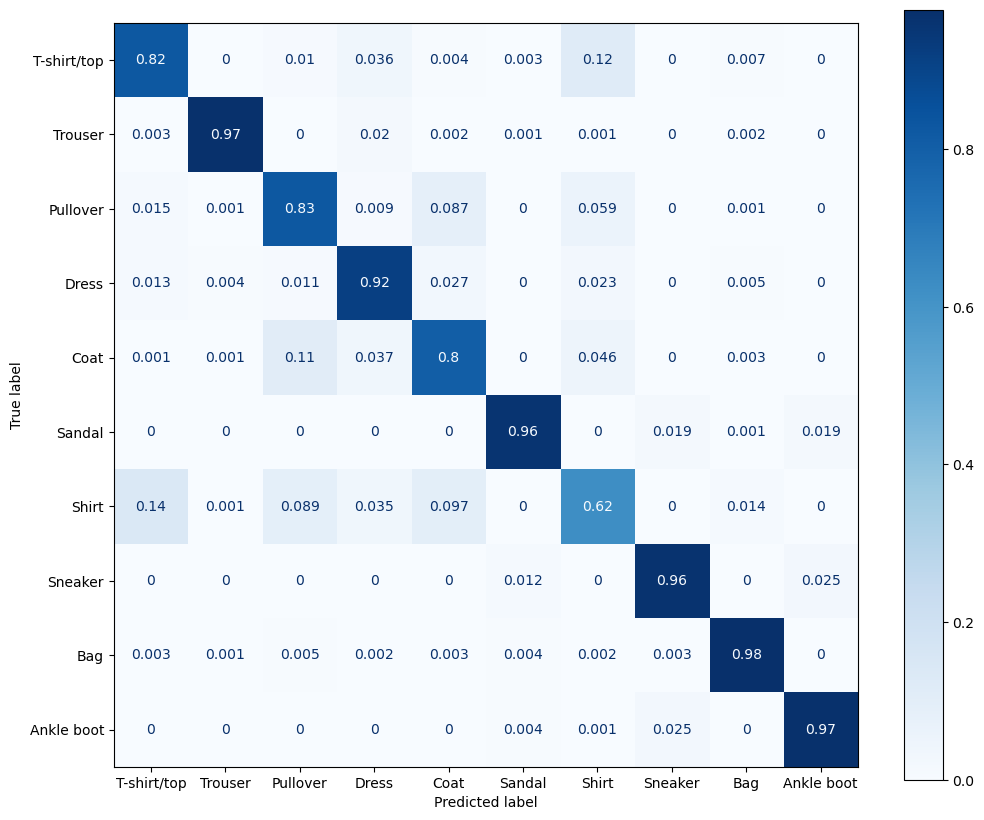

In [23]:
fig, ax = plt.subplots(figsize=(12, 10)) 

# Plot confusion matrix
# disp = ConfusionMatrixDisplay.from_predictions(
#     test_dataset.targets, y_pred
#     , display_labels=train_dataset.classes
#     , cmap='Blues'
#     , normalize='true', xticks_rotation=45
# );

disp.plot(ax=ax, cmap='Blues')
plt.show();

In [25]:
# Training/Test Loops (PyTorch Native)

def train_step(model, loader, loss_fn, optimizer, accuracy_fn, device):
    model.train()
    total_loss, total_acc = 0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy_fn(y_pred.argmax(dim=1), y).item()
    return total_loss / len(loader), total_acc / len(loader)

def test_step(model, loader, loss_fn, accuracy_fn, device):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            total_loss += loss.item()
            total_acc += accuracy_fn(y_pred.argmax(dim=1), y).item()
    return total_loss / len(loader), total_acc / len(loader)

In [24]:
# Set the final model with the best params (need to incl channels & dropout as such:)
model = SimpleCNN(
    channels=rs.best_params_["module__channels"]
    , dropout=rs.best_params_["module__dropout"]
).to(device)

model

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [ ]:
%%time

# Train the Best Model

optimizer = rs.best_params_["optimizer"](model.parameters(), lr=rs.best_params_["lr"])
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = Accuracy(task='multiclass', num_classes=10).to(device)

epochs = 20
for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(
        model, train_loader, loss_fn, optimizer, accuracy_fn, device)
    test_loss, test_acc = test_step(
        model, test_loader, loss_fn, accuracy_fn, device)
    print(
        f"Epoch {epoch+1}/{epochs} - "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f} - "
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}"
    )

  5%|██▏                                         | 1/20 [00:32<10:23, 32.81s/it]

Epoch 1/20 - Train Loss: 0.5316, Train Acc: 0.81 - Test Loss: 0.3961, Test Acc: 0.85


 10%|████▍                                       | 2/20 [00:59<08:40, 28.93s/it]

Epoch 2/20 - Train Loss: 0.3500, Train Acc: 0.87 - Test Loss: 0.3272, Test Acc: 0.88


 15%|██████▌                                     | 3/20 [01:25<07:50, 27.68s/it]

Epoch 3/20 - Train Loss: 0.3016, Train Acc: 0.89 - Test Loss: 0.2873, Test Acc: 0.90


 20%|████████▊                                   | 4/20 [01:51<07:16, 27.29s/it]

Epoch 4/20 - Train Loss: 0.2719, Train Acc: 0.90 - Test Loss: 0.2723, Test Acc: 0.90


 25%|███████████                                 | 5/20 [02:18<06:45, 27.07s/it]

Epoch 5/20 - Train Loss: 0.2498, Train Acc: 0.91 - Test Loss: 0.2572, Test Acc: 0.91


 30%|█████████████▏                              | 6/20 [02:45<06:17, 26.94s/it]

Epoch 6/20 - Train Loss: 0.2291, Train Acc: 0.92 - Test Loss: 0.2510, Test Acc: 0.91


In [18]:
results['params'].iloc[0]

{'optimizer': torch.optim.adam.Adam,
 'module__dropout': 0.25,
 'module__channels': 32,
 'lr': 0.0003,
 'batch_size': 256}

In [19]:
rs.best_estimator_

,module,<class '__main__.SimpleCNN'>
,criterion,<class 'torch...sEntropyLoss'>
,train_split,<skorch.datas...t 0x1a0490590>
,classes,None
,optimizer,<class 'torch...im.adam.Adam'>
,lr,0.001
,max_epochs,10
,batch_size,256
,iterator_train,<class 'torch...r.DataLoader'>
,iterator_valid,<class 'torch...r.DataLoader'>
,dataset,<class 'skorc...aset.Dataset'>


In [20]:
best_rand_cv = rs.best_estimator_
best_rand_cv

,module,<class '__main__.SimpleCNN'>
,criterion,<class 'torch...sEntropyLoss'>
,train_split,<skorch.datas...t 0x1a0490590>
,classes,None
,optimizer,<class 'torch...im.adam.Adam'>
,lr,0.001
,max_epochs,10
,batch_size,256
,iterator_train,<class 'torch...r.DataLoader'>
,iterator_valid,<class 'torch...r.DataLoader'>
,dataset,<class 'skorc...aset.Dataset'>


In [34]:
best_rand_cv.get_params

<bound method NeuralNet.get_params of <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SimpleCNN(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=3136, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
  ),
)>

In [22]:
# See classes
class_names = train_dataset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [24]:
# Predict with best estimator
y_pred = rs.best_estimator_.predict(
    X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

acc
print(report)
cm

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1000
           1       0.99      0.98      0.98      1000
           2       0.82      0.91      0.86      1000
           3       0.92      0.92      0.92      1000
           4       0.83      0.85      0.84      1000
           5       0.99      0.97      0.98      1000
           6       0.81      0.67      0.73      1000
           7       0.95      0.97      0.96      1000
           8       0.99      0.99      0.99      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



array([[883,   1,  16,  11,   3,   0,  80,   0,   6,   0],
       [  1, 984,   2,   8,   2,   0,   2,   0,   1,   0],
       [ 21,   1, 905,   6,  43,   0,  24,   0,   0,   0],
       [ 17,   9,  11, 917,  29,   0,  16,   0,   1,   0],
       [  1,   0,  94,  27, 850,   0,  28,   0,   0,   0],
       [  0,   0,   0,   0,   0, 974,   0,  25,   0,   1],
       [132,   1,  79,  23,  94,   0, 667,   0,   4,   0],
       [  0,   0,   0,   0,   0,   2,   0, 972,   0,  26],
       [  1,   2,   1,   2,   4,   1,   2,   1, 986,   0],
       [  0,   0,   0,   0,   0,   4,   1,  25,   0, 970]])

In [33]:
acc

0.9108

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay

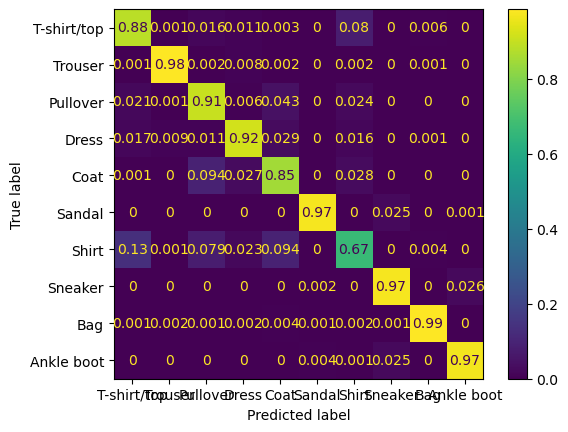

In [32]:
cmp = ConfusionMatrixDisplay.from_estimator(
    rs, X_test, y_test
    , normalize='true'
    , display_labels=class_names
);

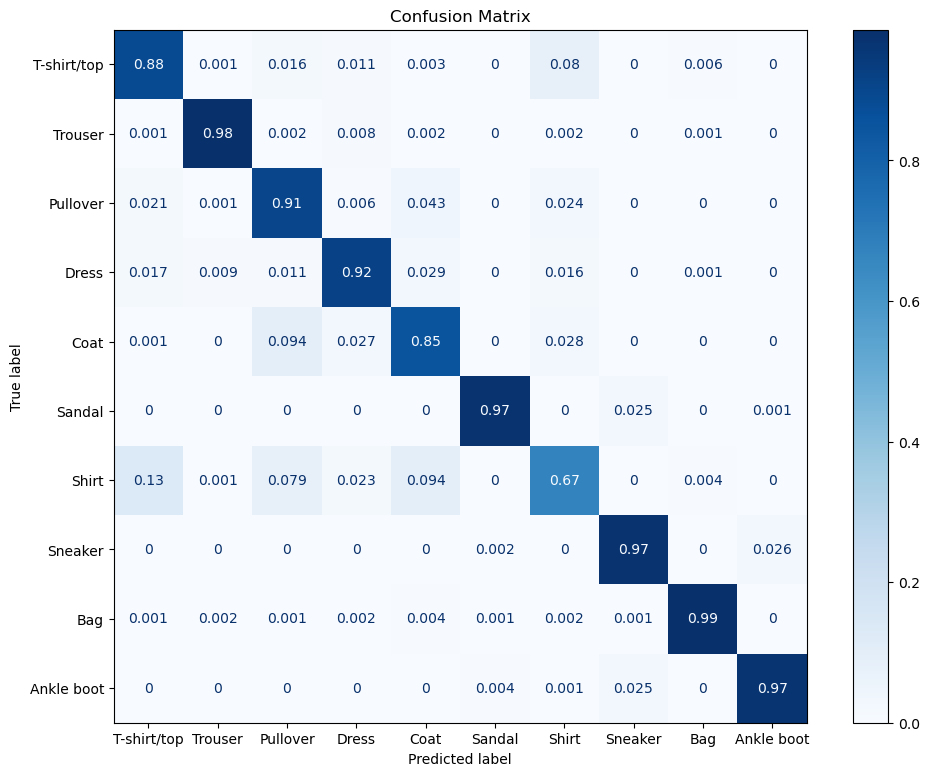

In [31]:
# Create a Matplotlib figure and axes with the desired figsize
fig, ax = plt.subplots(figsize=(12, 9)) # Adjust width and height as needed

# Create a ConfusionMatrixDisplay object (note creating an obj then running the object still outputs a mini cm, which looks strange, so just adding '.plot' to the end of the unnamed obj;)

cmp.plot(ax=ax, cmap='Blues')

# Add a title (optional)
ax.set_title('Confusion Matrix')

# Display the plot
plt.show();

In [37]:
best_rand_cv.get_params

<bound method NeuralNet.get_params of <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SimpleCNN(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=3136, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
  ),
)>

In [51]:
# Functionize the train & test loop(s):

def train_step(
    model: torch.nn.Module
    , data_loader: torch.utils.data.DataLoader
    , loss_fn: torch.nn.Module
    , optimizer: torch.optim.Optimizer
    , accuracy_fn
    , device: torch.device = device):
    
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(
            y_true=y
            , y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(
    data_loader: torch.utils.data.DataLoader
    , model: torch.nn.Module
    , loss_fn: torch.nn.Module
    , accuracy_fn
    , device: torch.device = device):
    
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(
                y_true=y
                , y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [53]:
# Import accuracy metric
from helper_functions import accuracy_fn 
# Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

import torchmetrics

accuracy_torch_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

accuracy_fn
accuracy_torch_fn

MulticlassAccuracy()

In [55]:
from timeit import default_timer as timer 

def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [56]:
# Move values to device
torch.manual_seed(27)
def eval_model(
    model: torch.nn.Module
    , data_loader: torch.utils.data.DataLoader 
    , loss_fn: torch.nn.Module
    , accuracy_fn
    , device: torch.device = device):   
    
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(
                y_true=y
                , y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__ 
            # ^^^ only works when model was created with a class
            , "model_loss": loss.item()
            , "model_acc": acc}

In [45]:
# ---------------------------------------------------------
# 1. Extract best parameters from skorch RandomizedSearchCV
# ---------------------------------------------------------
best_params = rs.best_params_
print("Best parameters:", best_params)

Best parameters: {'optimizer': <class 'torch.optim.adam.Adam'>, 'module__dropout': 0.25, 'module__channels': 32, 'lr': 0.001, 'batch_size': 256}


In [46]:
model_0x = SimpleCNN(
    channels=best_params["module__channels"]
    , dropout=best_params["module__dropout"]
).to(device)

In [48]:
# ---------------------------------------------------------
# 3. Define loss and optimizer using tuned learning rate
# ---------------------------------------------------------
loss_fn = nn.CrossEntropyLoss()

optimizer = best_params["optimizer"](
    params=model_0x.parameters()
    , lr=best_params["lr"]
)

In [49]:
# ---------------------------------------------------------
# 4. Prepare DataLoaders (with tuned batch size)
# ---------------------------------------------------------
train_dataloader = DataLoader(
    train_dataset
    , batch_size=best_params["batch_size"]
    , shuffle=True
)

test_dataloader = DataLoader(
    test_dataset
    , batch_size=best_params["batch_size"]
    , shuffle=False
)

In [58]:
# ---------------------------------------------------------
# 5. Training + Testing Loops
# ---------------------------------------------------------
torch.manual_seed(27)

from timeit import default_timer as timer
from tqdm.auto import tqdm

train_time_start = timer()

epochs = 20
for epoch in tqdm(range(epochs)):
    print(f"\nEpoch: {epoch+1}/{epochs}")
    
    # --- Training ---
    train_step(
        data_loader=train_dataloader
        , model=model_0x
        , loss_fn=loss_fn
        , optimizer=optimizer
        , accuracy_fn=accuracy_fn
        , device=device
    )

    # --- Testing ---
    test_step(
        data_loader=test_dataloader
        , model=model_0x
        , loss_fn=loss_fn
        , accuracy_fn=accuracy_fn
        , device=device
    )

train_time_end = timer()
total_train_time = print_train_time(
    start=train_time_start
    , end=train_time_end
    , device=device
)

print(f"Training complete in {total_train_time:.2f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 1/20
Train loss: 0.04623 | Train accuracy: 98.34%
Test loss: 0.30015 | Test accuracy: 92.29%


Epoch: 2/20
Train loss: 0.03858 | Train accuracy: 98.70%
Test loss: 0.33791 | Test accuracy: 92.13%


Epoch: 3/20
Train loss: 0.03514 | Train accuracy: 98.80%
Test loss: 0.35285 | Test accuracy: 91.88%


Epoch: 4/20
Train loss: 0.03056 | Train accuracy: 98.97%
Test loss: 0.37592 | Test accuracy: 91.70%


Epoch: 5/20
Train loss: 0.02583 | Train accuracy: 99.15%
Test loss: 0.36470 | Test accuracy: 92.08%


Epoch: 6/20
Train loss: 0.02193 | Train accuracy: 99.34%
Test loss: 0.44778 | Test accuracy: 91.27%


Epoch: 7/20
Train loss: 0.02055 | Train accuracy: 99.34%
Test loss: 0.38481 | Test accuracy: 92.18%


Epoch: 8/20
Train loss: 0.02097 | Train accuracy: 99.29%
Test loss: 0.45152 | Test accuracy: 91.22%


Epoch: 9/20
Train loss: 0.02148 | Train accuracy: 99.29%
Test loss: 0.43041 | Test accuracy: 91.80%


Epoch: 10/20
Train loss: 0.01665 | Train accuracy: 99.45%
Test loss: 0.45639 | Te

In [59]:
# Get model results 
model_0x_results = eval_model(
    model=model_0x
    , data_loader=test_dataloader
    , loss_fn=loss_fn
    , accuracy_fn=accuracy_fn
)
model_0x_results

{'model_name': 'SimpleCNN',
 'model_loss': 0.5575814247131348,
 'model_acc': 92.5390625}

In [62]:
import random
random.seed(27)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 7 (Sneaker)


In [63]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [65]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_0x, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[2.4747e-19, 7.4161e-24, 1.1800e-18, 4.3732e-28, 1.4310e-24, 2.6814e-21,
         1.3605e-30, 1.0000e+00, 9.2474e-19, 2.0304e-24],
        [1.0000e+00, 1.1740e-23, 3.4464e-18, 3.5517e-14, 3.6197e-23, 2.5201e-23,
         1.0441e-15, 1.2400e-19, 6.9487e-21, 1.8875e-22]])

In [66]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([7, 0, 6, 9, 5, 6, 3, 9, 5])

In [67]:
# Are our predictions in the same form as our test labels? 
test_labels, pred_classes

([7, 0, 2, 9, 5, 6, 3, 9, 5], tensor([7, 0, 6, 9, 5, 6, 3, 9, 5]))

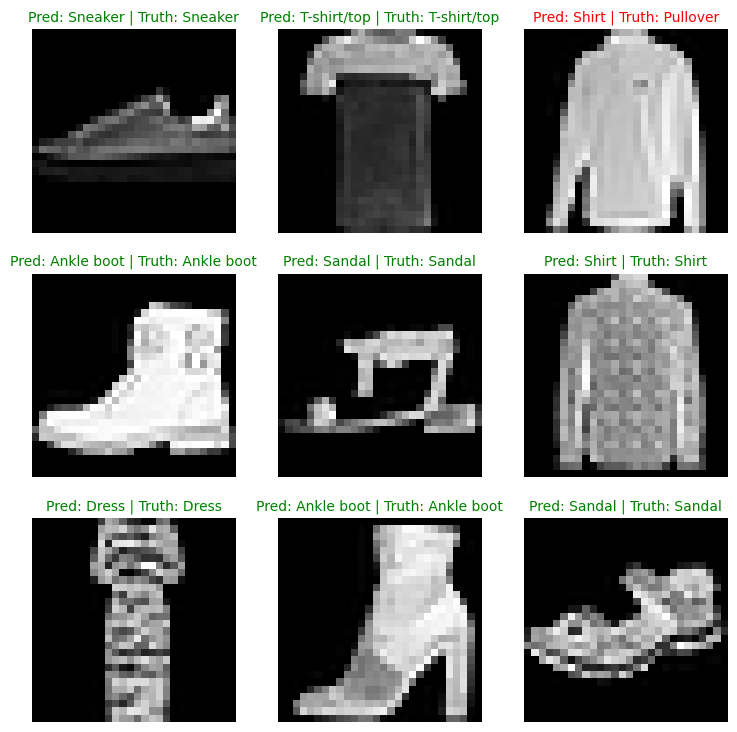

In [68]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

In [69]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_0x.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_0x(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/40 [00:00<?, ?it/s]

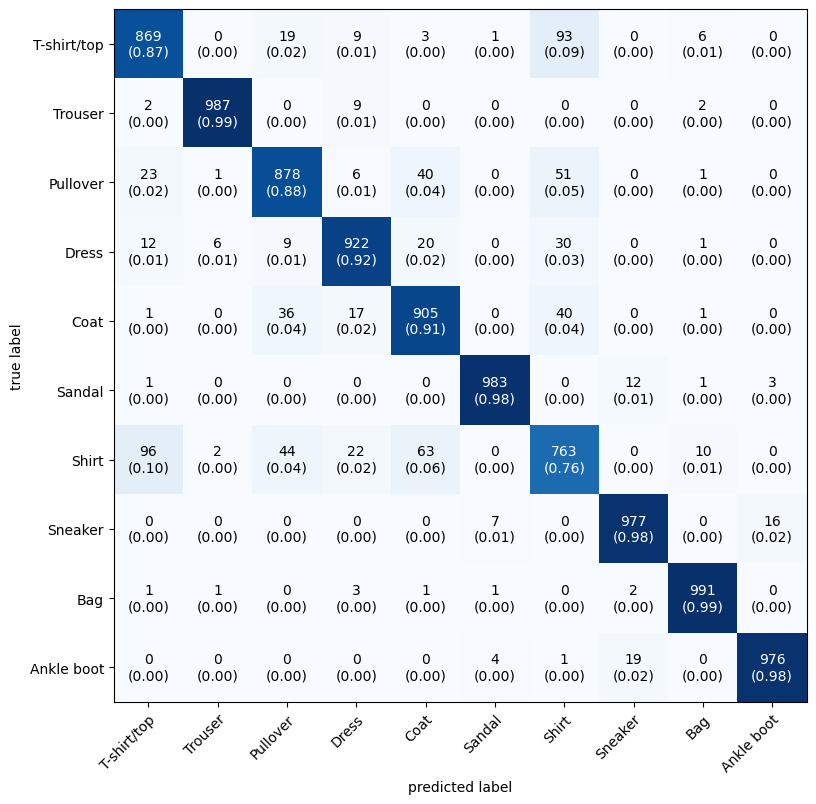

In [89]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 1. Create confusion matrix
cm2 = ConfusionMatrix(
    num_classes=len(class_names)
    , task='multiclass'
#     , normalize="true"
)

cm2_tensor = cm2(
    preds=y_pred_tensor
    , target=test_dataset.targets)

# 2. Convert to NumPy
cm2_numpy = cm2_tensor.numpy()

# 3. Plot confusion matrix with formatted values
fig, ax = plot_confusion_matrix(
    conf_mat=cm2_numpy
    , class_names=class_names
    , figsize=(12, 9)
    , show_normed=True  # Normalized values
)

In [54]:
# 4. Define parameter grid
#    Note: use 'module__' prefix for module args

param_grid = {
    "module__channels": [32, 64]
    , "module__dropout": [0.0, 0.25, 0.5] 
    , "lr": [1e-4, 3e-4, 1e-3]
    , "optimizer": [torch.optim.Adam]
    , "batch_size": [256]
    , "max_epochs": [3]
}

In [61]:
best_net = NeuralNetClassifier(
    module=SimpleCNN
    , criterion=nn.CrossEntropyLoss
    , max_epochs=20
    , lr=0.0003
    , optimizer=torch.optim.Adam
    , batch_size=256
    , iterator_train__shuffle=True
    , device=device
)

best_net.fit(X_train, y_train)
print("Train accuracy:", best_net.score(X_train, y_train))

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.8366       0.8685        0.3710  15.5156
      2        0.3276       0.8840        0.3169  15.5024
      3        0.2766       0.8964        0.2846  16.8444
      4        0.2432       0.9051        0.2634  16.1104
      5        0.2250       0.8996        0.2804  16.0984
      6        0.2091       0.9104        0.2495  16.1239
      7        0.1855       0.9092        0.2460  16.1975
      8        0.1718       0.9107        0.2536  15.7750
      9        0.1641       0.9103        0.2449  15.8042
     10        0.1480       0.9035        0.2779  15.8287
     11        0.1358       0.9100        0.2621  15.6743
     12        0.1285       0.9146        0.2524  15.8504
     13        0.1145       0.9173        0.2499  15.6497
     14        0.1037       0.9168        0.2536  15.6584
     15        0.0999       0.9130        0.2649  15.7950
     16       

In [62]:
best_net.get_params

<bound method NeuralNet.get_params of <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SimpleCNN(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=3136, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  ),
)>

In [63]:
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay)

In [ ]:
"""
# Predict with best estimator
y_pred = grid_search.best_estimator_.predict(
    X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

"""

In [64]:
final_model = NeuralNetClassifier(
    channels=best_params["channels"]
    , dropout=best_params["dropout"]
).to(device)

NameError: name 'best_params' is not defined

In [ ]:
# 5A. Exhaustive Grid Search (slow but complete)
# ---------------------------------------------------------
gs = GridSearchCV(
    estimator=net
    , param_grid=param_grid
    , cv=3               # 3-fold cross validation
    , scoring="accuracy" # use accuracy for FashionMNIST
    , verbose=2
    , n_jobs=-1          # parallelize if possible
)

# Fit the grid search
gs.fit(X, y)

print("Best CV accuracy:", gs.best_score_)
print("Best params:", gs.best_params_)